📁 2. 데이터셋 준비 (TensorFlow ImageDataGenerator)

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. 학습 데이터에만 증강 적용
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# 2. 검증/테스트 데이터는 단순 정규화만
test_datagen = ImageDataGenerator(rescale=1./255)

# 3. 데이터 불러오기
train_generator = train_datagen.flow_from_directory(
    'COVID19-dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # 다중분류이므로 categorical
)

val_generator = test_datagen.flow_from_directory(
    'COVID19-dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'COVID19-dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


🧹 3. 데이터 전처리
이미 ImageDataGenerator(rescale=1./255)을 통해 정규화 (0~1 스케일) 적용

클래스 수 확인:

In [2]:
print(train_generator.class_indices)
# {'Covid': 0, 'Normal': 1, 'Pneumonia': 2}


{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


🧠 4. Pretrained 모델 로드 + 분류층 추가 + 컴파일

In [3]:
# MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Pretrained 모델 불러오기 (top 없애기)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 분류층 쌓기
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# base_model은 학습 고정 (원하는 경우 fine-tuning 가능)
for layer in base_model.layers:
    layer.trainable = False

# 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# Xception
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Pretrained Xception 모델 불러오기 (top 제거)
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 새로운 분류층 쌓기
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# base_model 레이어는 학습 고정 (필요시 fine-tuning 가능)
for layer in base_model.layers:
    layer.trainable = False

# 컴파일
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


83683744/83683744 [==============================] - 4s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                    

In [8]:
# VGG19
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Pretrained VGG19 모델 불러오기 (include_top=False)
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 새로운 분류층 쌓기
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# 최종 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# base_model 레이어는 학습 고정 (필요시 fine-tuning 가능)
for layer in base_model.layers:
    layer.trainable = False

# 컴파일
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

🏋️ 5. 모델 학습

In [9]:
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator
)

Epoch 1/60
8/8 [==============================] - 12s 1s/step - loss: 1.1925 - accuracy: 0.4263 - val_loss: 1.1542 - val_accuracy: 0.5758
Epoch 2/60
8/8 [==============================] - 4s 518ms/step - loss: 1.1536 - accuracy: 0.4741 - val_loss: 1.0640 - val_accuracy: 0.6515
Epoch 3/60
8/8 [==============================] - 4s 533ms/step - loss: 1.0959 - accuracy: 0.4622 - val_loss: 1.0189 - val_accuracy: 0.6667
Epoch 4/60
8/8 [==============================] - 4s 511ms/step - loss: 1.0598 - accuracy: 0.4382 - val_loss: 0.9954 - val_accuracy: 0.6364
Epoch 5/60
8/8 [==============================] - 4s 524ms/step - loss: 1.0396 - accuracy: 0.4741 - val_loss: 0.9777 - val_accuracy: 0.6667
Epoch 6/60
8/8 [==============================] - 4s 523ms/step - loss: 0.9851 - accuracy: 0.5219 - val_loss: 0.9603 - val_accuracy: 0.6818
Epoch 7/60
8/8 [==============================] - 4s 525ms/step - loss: 1.0076 - accuracy: 0.5139 - val_loss: 0.9445 - val_accuracy: 0.6667
Epoch 8/60
8/8 [======

📈 6. 학습 과정 시각화

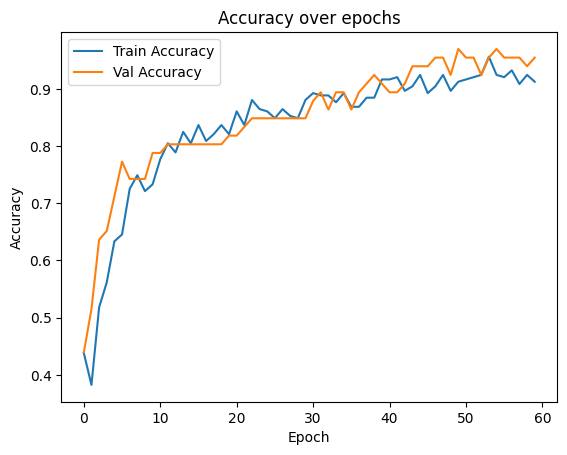

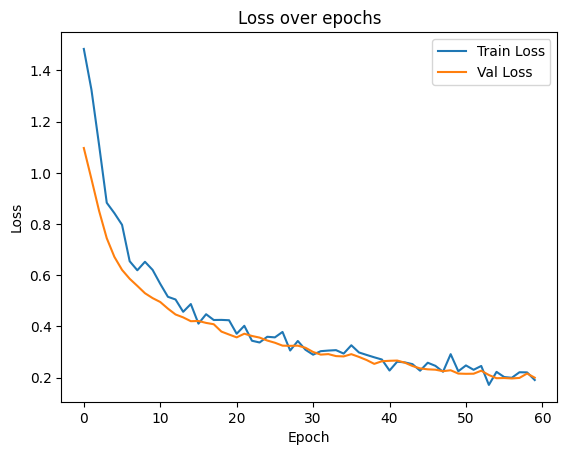

In [5]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


📊 7. 모델 평가

In [6]:
loss, acc = model.evaluate(test_generator)
print("Test Accuracy:", acc)


3/3 [==============================] - 1s 74ms/step - loss: 0.1997 - accuracy: 0.9545
Test Accuracy: 0.9545454382896423


🖼️ 8. 모델 예측 결과 출력

1/1 [==============================] - 0s 370ms/step


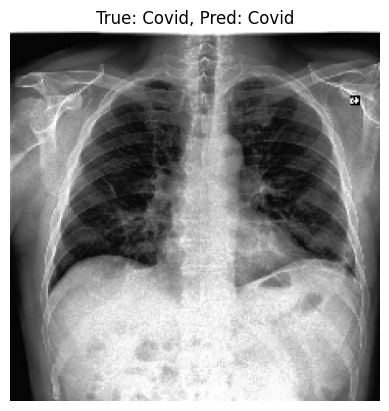

In [7]:
import numpy as np

# 예측 결과
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 예시 이미지 시각화
import matplotlib.pyplot as plt

for i in range(5):
    img, label = test_generator[i]
    pred_label = np.argmax(model.predict(img), axis=1)

    plt.imshow(img[0])
    plt.title(f"True: {class_labels[np.argmax(label[0])]}, Pred: {class_labels[pred_label[0]]}")
    plt.axis('off')
    plt.show()
    break  # 한번만 출력
